In [1]:
%reload_kedro

2020-03-26 11:29:33,184 - root - INFO - ** Kedro project Dynamic Topic Modeling
2020-03-26 11:29:33,184 - root - INFO - Defined global variable `context` and `catalog`


In [2]:
import pandas as pd
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [3]:
docs = pd.read_csv("data/03_primary/un-general-debates-preprocessed.csv")
docs = docs.drop(columns=["session", "country", "timeslice"])
docs["text"] = docs["text"].apply(lambda doc: doc[1:-1].replace("'", "").replace(",", "").split(" "))
docs

,timestamp,text
0,1970,"[general, assembly, fortunate, indeed, preside..."
1,1970,"[give, great, pleasure, mr, president, extend,..."
2,1970,"[mr, president, behalf, excellency, mzee, jomo..."
3,1970,"[mr, president, pleasure, speak, time, presidi..."
4,1970,"[may, say, delegation, malaysia, philippine, d..."
...,...,...
7502,2015,"[would, first, like, congratulate, mr, preside..."
7503,2015,"[distinct, honour, privilege, participate, pro..."
7504,2015,"[enormously, happy, behalf, bolivian, people, ..."
7505,2015,"[costa, rica, would, like, congratulate, sir, ..."


# Doc2Vec

In [4]:
def read_corpus(docs):
    for i, text in enumerate(docs):
        yield TaggedDocument(text, [i])

In [5]:
corpus = list(read_corpus(docs["text"]))

In [6]:
model = Doc2Vec(vector_size=300, min_count=2, epochs=50)

In [7]:
model.build_vocab(corpus)

2020-03-26 10:46:09,916 - gensim.models.doc2vec - INFO - collecting all words and their counts
2020-03-26 10:46:09,918 - gensim.models.doc2vec - INFO - PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2020-03-26 10:46:11,588 - gensim.models.doc2vec - INFO - collected 46754 word types and 7507 unique tags from a corpus of 7507 examples and 11265309 words
2020-03-26 10:46:11,589 - gensim.models.word2vec - INFO - Loading a fresh vocabulary
2020-03-26 10:46:11,647 - gensim.models.word2vec - INFO - effective_min_count=2 retains 31139 unique words (66% of original 46754, drops 15615)
2020-03-26 10:46:11,648 - gensim.models.word2vec - INFO - effective_min_count=2 leaves 11249694 word corpus (99% of original 11265309, drops 15615)
2020-03-26 10:46:11,737 - gensim.models.word2vec - INFO - deleting the raw counts dictionary of 46754 items
2020-03-26 10:46:11,738 - gensim.models.word2vec - INFO - sample=0.001 downsamples 33 most-common words
2020-03-26 10:46:11,739 - gensim.

In [ ]:
model.train(corpus, total_examples=model.corpus_count, epochs=model.epochs, report_delay=60.0)

In [4]:
import pickle

In [9]:
pickle.dump(model, open('model_doc2vec.pkl', "wb"))

In [5]:
model = pickle.load(open("model_doc2vec.pkl", "rb"))

In [6]:
n_clusters = 7

In [7]:
km = KMeans(n_clusters=n_clusters, n_jobs=-1)
X = km.fit(model.docvecs.vectors_docs)

In [8]:
points = pd.DataFrame(TSNE(n_components=2).fit_transform(model.docvecs.vectors_docs))
points['target'] = km.labels_

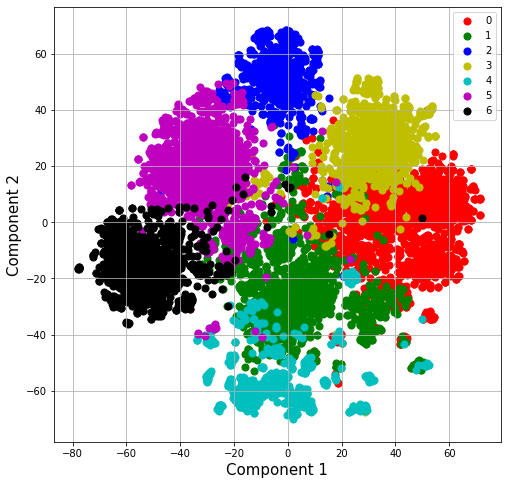

In [9]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Component 1', fontsize = 15)
ax.set_ylabel('Component 2', fontsize = 15)

targets = [0, 1, 2, 3, 4, 5, 6]
colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k']
for target, color in zip(targets, colors):
    indicesToKeep = points['target'] == target
    ax.scatter(points.loc[indicesToKeep, 0]
               , points.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

# Stats on clusters

In [10]:
points['text'] = docs['text'].apply(lambda x: " ".join(word for word in x))
points

,0,1,target,text
0,17.553682,10.132010,1,general assembly fortunate indeed president ye...
1,19.724480,15.341299,3,give great pleasure mr president extend sincer...
2,21.351240,22.659185,3,mr president behalf excellency mzee jomo kenya...
3,-50.542538,14.801188,5,mr president pleasure speak time presiding mee...
4,19.759850,11.014279,0,may say delegation malaysia philippine delegat...
...,...,...,...,...
7502,15.526899,32.662621,3,would first like congratulate mr president ele...
7503,-19.089125,14.388291,5,distinct honour privilege participate proceedi...
7504,-77.821129,-16.050961,6,enormously happy behalf bolivian people expres...
7505,12.425817,-7.920104,1,costa rica would like congratulate sir electio...


In [11]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

## Most frequent words per topic using CountVectorizer

In [12]:
n = 8

In [13]:
for target in targets:
    indicesToKeep = points['target'] == target
    cor = list(points.loc[indicesToKeep, "text"])
    vec = CountVectorizer(max_df=0.8, ngram_range=(1,2)).fit(cor)
    bag_of_words = vec.transform(cor)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    print(str(target) + " : " + str([x[0] for x in words_freq[:n]]))

0 : ['problem', 'south', 'developing country', 'island', 'small', 'nuclear', 'change', 'conference']
1 : ['problem', 'european', 'nuclear', 'war', 'operation', 'weapon', 'conference', 'session']
2 : ['iraq', 'israeli', 'developing', 'lebanon', 'weapon', 'africa', 'aggression', 'nuclear']
3 : ['south', 'south africa', 'delegation', 'developing country', 'conference', 'power', 'independence', 'namibia']
4 : ['nuclear', 'weapon', 'soviet', 'democratic', 'military', 'operation', 'united state', 'disarmament']
5 : ['south', 'crisis', 'relation', 'war', 'delegation', 'operation', 'force', 'power']
6 : ['american', 'solution', 'latin', 'human right', 'power', 'policy', 'war', 'developing']


## Most frequent words per topic using tf-idf

In [14]:
top_words = []
for target in targets:
    indicesToKeep = points['target'] == target
    cor = list(points.loc[indicesToKeep, "text"])
    vec = TfidfVectorizer(max_df=0.8, ngram_range=(1,2)).fit(cor)
    bag_of_words = vec.transform(cor)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    top_words.append([x[0] for x in words_freq[:25]])
    print(str(target) + " : " + str([x[0] for x in words_freq[:n]]))

0 : ['island', 'south', 'nuclear', 'problem', 'small', 'developing country', 'change', 'pacific']
1 : ['problem', 'nuclear', 'european', 'operation', 'cooperation', 'weapon', 'europe', 'conference']
2 : ['iraq', 'lebanon', 'israeli', 'terrorism', 'developing', 'nuclear', 'aggression', 'weapon']
3 : ['south', 'south africa', 'delegation', 'developing country', 'namibia', 'conference', 'nuclear', 'power']
4 : ['nuclear', 'weapon', 'soviet', 'co', 'co operation', 'cooperation', 'operation', 'disarmament']
5 : ['south', 'co', 'guinea', 'delegation', 'operation', 'crisis', 'co operation', 'relation']
6 : ['co', 'american', 'human right', 'latin', 'democracy', 'central', 'solution', 'council']


# Metrics

In [22]:
import numpy as np

In [35]:
TD = len(np.unique(top_words))/(7*25)
print('Overall Topic Diversity : {}'.format(TD))

Overall Topic Diversity : 0.5714285714285714
